## Generative Adversarial Networks
This notebook will build the most basic GAN possible. It will use 2 simple, fully-connected networks to learn how to draw a single digit ('7') from the MNIST dataset. 

First, get the dataset from the repository:

In [1]:
#Download the dataset from github

!git clone https://github.com/gregd190/Image-Classification---MNIST-Dataset---NN-Solutions
!cp -r Image-Classification---MNIST-Dataset---NN-Solutions/. /content/


fatal: destination path 'Image-Classification---MNIST-Dataset---NN-Solutions' already exists and is not an empty directory.


Import the necessary libraries:

In [2]:
#Import the necessary libraries

import numpy as np
import keras
import struct
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers


Using TensorFlow backend.


Preprocess the data:

In [0]:
# The MNIST data is provided in a file format that needs to be read before the data can be fed to the neural network. 
def read_data(image_filename, label_filename):
    
    #Create arrays to store labels and pixel data
    label_array = []
    image_array = []
    
    # Load everything in some numpy arrays
    with open(label_filename, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(image_filename, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    for i in range(len(lbl)):
        label_array.append(lbl[i])
        image_array.append(img[i])
    
    #Convert arrays to np.arrays
    image_array = np.array(image_array)
    label_array = np.array(label_array)
    
    return(image_array, label_array)


Check that the data arrays look correct:

In [4]:
train_images, train_labels = read_data('train-images.idx3-ubyte', 'train-labels.idx1-ubyte')
print('Shape of train_labels = ',np.shape(train_labels))
print('Shape of train_images = ', np.shape(train_images))

print('train_labels[0:5] = ', train_labels[0:5])


Shape of train_labels =  (60000,)
Shape of train_images =  (60000, 28, 28)
train_labels[0:5] =  [5 0 4 1 9]


Find the array indexes of the number 5

In [5]:
sevens_index = np.nonzero(train_labels==7)

#Test they are all 7's
print(train_labels[sevens_index])

sevens = train_images[sevens_index]
np.shape(sevens)



[7 7 7 ... 7 7 7]


(6265, 28, 28)

We have a training set of 6265 images of the digit 7.


Let's build the networks. 

In [6]:
def build_discriminator_model(input_shape, num_output_nodes, lr, size):
    
    model = Sequential()
    
    model.add(Dense(size[0], input_shape = input_shape, activation = 'relu'))
    
    for i in range(1,len(size)):
        model.add(Dense(size[i], activation = 'relu'))
        model.add(Dropout(0.5))
    
    model.add(Dense(num_output_nodes, activation = 'sigmoid')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

def build_generator_model(input_shape, num_output_nodes, lr, size):
    
    model = Sequential()
    
    model.add(Dense(size[0], input_shape = input_shape, activation = 'relu'))
    
    for i in range(1,len(size)):
        model.add(Dense(size[i], activation = 'relu'))
    
    model.add(Dense(num_output_nodes, activation = 'sigmoid')) 
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999)
    
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    
    model.summary()
    
    return model

#Discriminator takes input of 784 pixels  
discriminator = build_discriminator_model((784,), 1, 1e-4, [256,128,64])

#Generator will take 100 inputs of random noise
generator = build_generator_model((100,), 784, 1e-5, [64,128,256]) 



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 242,177
Trainable params: 242,177
Non-trainable params: 0
_________________________________________________________________
____

In [0]:
def build_gan_model(discriminator, generator):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(100,))
    # the output of the generator (an image)
    generated_image = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(generated_image)
    gan = Model(inputs=gan_input, outputs=gan_output)
    adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
    gan.compile(loss='binary_crossentropy', optimizer=adam)
    return gan

gan_model = build_gan_model(discriminator, generator) 

We need a way of determining whether to feed an image from the training set, or an image from the generator to the discriminator. We'll create a function that decides based on a 50:50 split

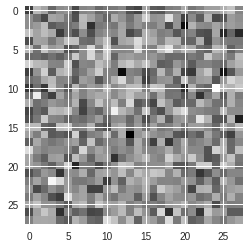

In [8]:
def plot_generated_image():
  noise = np.array([np.random.uniform(0,1,100)])
  generated_image = generator.predict(noise)
  generated_image = generated_image.reshape(28, 28)
  
  return(generated_image)
  
#Test it - At this stage it should just be random pixels
plt.imshow(plot_generated_image(), interpolation='nearest', cmap='gray_r')


In [0]:
#Will return either a randomly generated image, or an image from the training set, plus either a 0 or 1, indicating whether the image is real(1) or generated(0)

def pick_image():
  if np.random.uniform() < 0.5:
    a = np.random.randint(0,len(sevens))
    #print('TRUE IMAGE', np.shape(np.ndarray.flatten(sevens[a])))
    return(np.reshape(sevens[a],(1,784)),1)
  else:
    random_inputs = np.array([np.random.uniform(0,1,100)])
    generated_image = generator.predict(random_inputs)      
    #print('FAKE IMAGE', np.shape(generated_image))
    return(generated_image,0)

  

Now we need to feed our image into our discriminator model, and then train the two models based on the accuracy of the prediction:

In [0]:
def train(batches=1, batch_size=256):
    
    #Create a list to store images generated after every 100 batches
    generated_images = []
    
    for e in range(1, batches+1):
        #Print images every 1000 batches
        if e%100==0:
          print('After ', e,' batches:')
          #image = [plot_generated_image() for i in range(25)]
          #image = np.reshape(image,(140,140))
            
          plt.imshow(plot_generated_image(), cmap='gray_r')
          #ticks = [28*i for i in range(5)]
          #plt.xticks(ticks)
          #plt.yticks(ticks)
          #plt.grid(color='r')
          plt.show()
          
           
        #Initialize arrays for storage of images and labels for the entire batch
        images_array = []
        labels_array = []
        
        #Get images and labels
        for b in range(batch_size):
        
          image, label = pick_image()
          images_array.append(image)
          labels_array.append([label])
        
        images_array = np.array(images_array)
        images_array = np.reshape(images_array,(batch_size,784))
        labels_array = np.array(labels_array)
        
        # Train discriminator
        discriminator.trainable = True
        history = discriminator.fit(images_array, labels_array, verbose=False)
        discriminator_loss_history.append(history.history["loss"])

        # Train generator
        noise_array = np.random.uniform(0,1,size=[batch_size,100])
        ones_array = np.ones((batch_size,1))
        
        discriminator.trainable = False
        history = gan_model.fit(noise_array, ones_array, verbose=False)
        gan_loss_history.append(history.history["loss"])
        
    return(generated_images)

# Initialise arrays to store the loss information during training.         
discriminator_loss_history = []
gan_loss_history = []




After  100  batches:


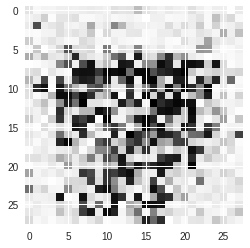

After  200  batches:


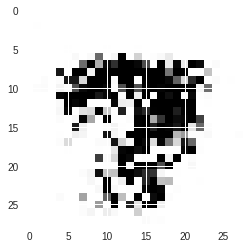

After  300  batches:


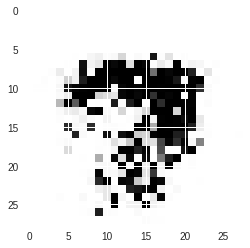

After  400  batches:


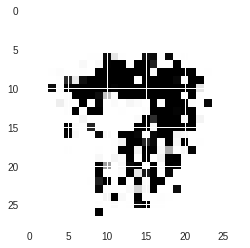

After  500  batches:


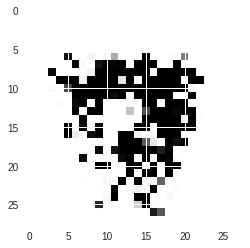

After  600  batches:


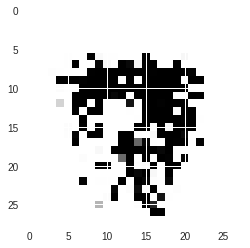

After  700  batches:


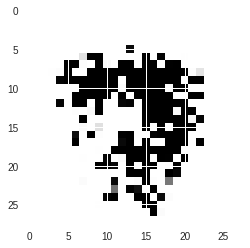

After  800  batches:


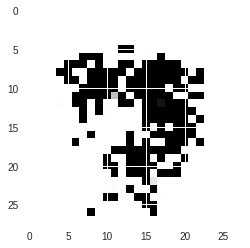

After  900  batches:


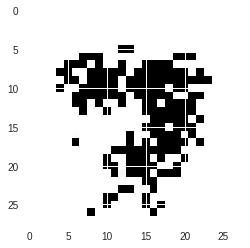

After  1000  batches:


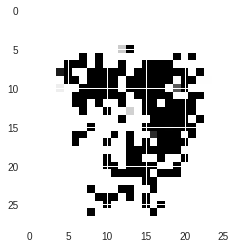

After  1100  batches:


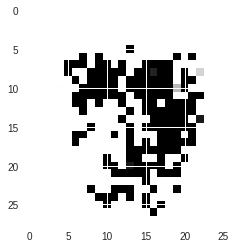

After  1200  batches:


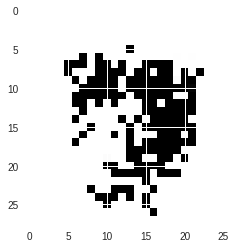

After  1300  batches:


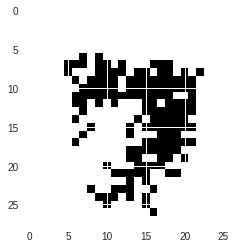

After  1400  batches:


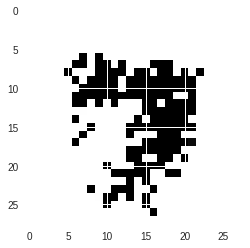

After  1500  batches:


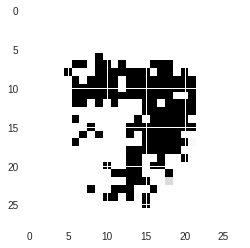

After  1600  batches:


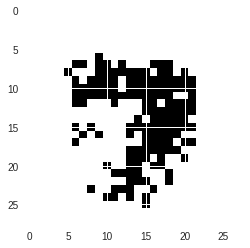

After  1700  batches:


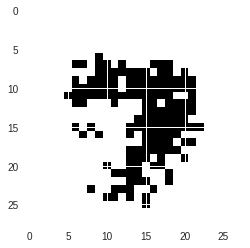

In [0]:
train(5000)



Plot the loss of the models vs training iterations to allow optimisation of the hyperparameters and to know when further training is unlikely to lead to further improvement.

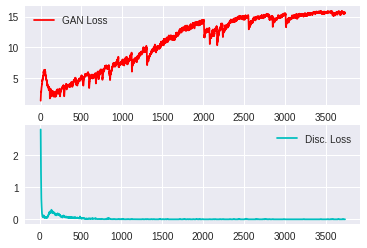

In [43]:
#Discriminator loss is extremely spiky. We'll smooth it to better see trends. 
discriminator_loss_rolling_avg =[]
discriminator_loss_iter_counter = []
for i in range(10,len(discriminator_loss_history)):
  discriminator_loss_rolling_avg.append(np.average(discriminator_loss_history[i-10:i]))
  discriminator_loss_iter_counter.append(i)
  
plt.subplot('211')
plt.plot(gan_loss_history,'r', label='GAN Loss')
plt.legend()
plt.subplot('212')
plt.plot(discriminator_loss_iter_counter,discriminator_loss_rolling_avg,'c', label='Disc. Loss')
plt.legend()
plt.show()

## Summary

A very simple generative adversarial network was trained to draw a single digit. This could easily be expanded to draw any digit by training on the entire MNIST dataset. It may be improved, either in final quality or by allowing training to occur over a smaller number of iterations through the implementation of a convolutional neural network.  